In [1]:
import copy
import os
import numpy as np
import csv
import numpy as np
import argparse

import json
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from set_analyze.my_diff_color import *

from cache_sensitive_names import *

cache_type = 'goldencove'

select_json = f'/nfs/home/zhangchuanqi/lvna/5g/lazycat-data_proc/set_analyze/conf-json/conf_{cache_type}_tailbm50M.json'

with open(select_json,'r') as f:
        use_conf = json.load(f)

test_prefix = use_conf['test_prefix']
perf_prefix = '95perf'
pic_dir_path = f'{test_prefix}pics'

ncore = 4
napps = 3
app_labels = ['HP0','HP1','BE']

work0names = use_conf['cache_work_names']


print(work0names)

xlsx_file = f'/nfs/home/zhangchuanqi/lvna/5g/lazycat-data_proc/set_analyze/asplos23-mix{ncore}-2hp-{test_prefix}allpolicy.xlsx'

all_sheets = pd.read_excel(xlsx_file, sheet_name=None)

# w0s = ["astar_biglakes", "xalancbmk","omnetpp","gcc_200","soplex_pds","gcc_cpdecl","sphinx3",
#  "cactusADM", "gcc_g23", "mcf", "gcc_scilab", "lbm",]
w0s = work0names
w0xlabels = work0names + ['overall']

parameters = {'axes.labelsize': 36,
        'axes.titlesize': 30,
        'xtick.labelsize': 30,
        'ytick.labelsize': 30,
        'legend.fontsize': 26,
        'font.size': 45,
        'lines.linewidth': 3,
        }
plt.rcParams.update(parameters)
fig_inchs = (40,6)

['cam4', 'fotonik3d', 'lbm', 'omnetpp', 'parest', 'roms', 'xalancbmk', 'cc_sv', 'pr_spmv', 'tc', 'imgdnn', 'sphinx', 'xapian']


In [2]:
sheet32 = all_sheets['32bucket']
expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]

looptime = 0
for index,row in sheet32.iterrows():
    print(row['workload0'],row['workload1'], end='\t')
    for e in exps:
        print(row[e], end='\t')
    print()
    looptime += 1
    if looptime > 5:
        break

lbm cc_sv	1.002996623653544	0.9965514303926493	1.010082916188163	1.004915992238901	
parest fotonik3d	0.9852653637442971	0.995403849184678	1.010819068665755	1.005296174951558	
xapian lbm	0.975662482288962	1.005436017058375	1.016341082393702	1.020279039180569	
fotonik3d omnetpp	1.003558353302592	1.011728288246717	1.044084478678951	1.024957147613626	
xapian lbm	0.9743340601004834	0.9965582918434858	1.00662653940318	1.028345855190713	
cam4 cc_sv	0.9831324639128991	1.00609009169853	1.029006148915292	1.061771337195911	


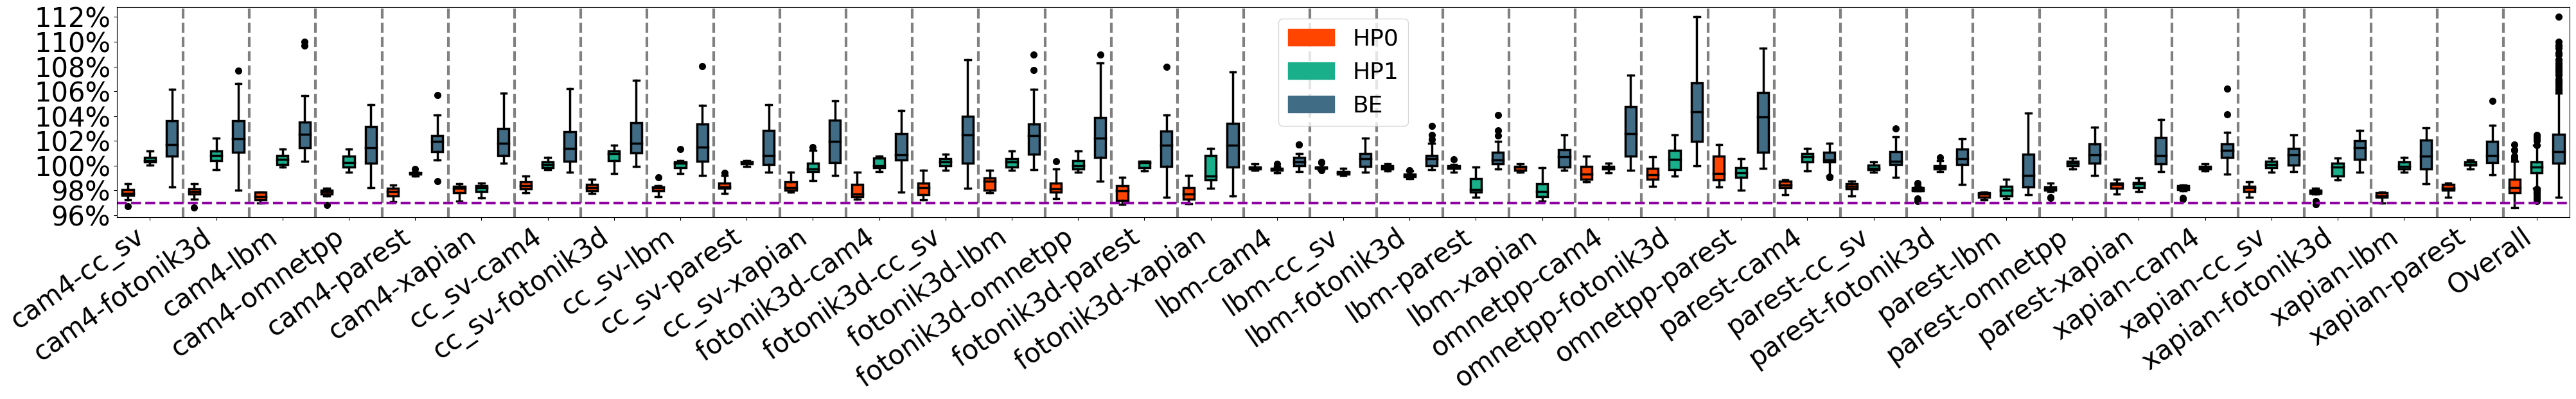

In [3]:
sheet32 = all_sheets['32bucket']

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]

data = []

overall_datas = [ [] for _ in range(napps) ]

hp2_data_dict = {}
for index,row in sheet32.iterrows():
    hp2_key = row['workload0'] + '-' + row['workload1']
    if hp2_key not in hp2_data_dict:
        hp2_data_dict[hp2_key] = [ [] for _ in range(napps) ]
    hp0 = row[exps[0]]
    hp1 = row[exps[1]]
    bes = [row[exps[j]] for j in range(2, ncore)]
    hp2_data_dict[hp2_key][0].append(hp0)
    hp2_data_dict[hp2_key][1].append(hp1)
    # hp2_data_dict[hp2_key][2].append(np.average(bes))
    hp2_data_dict[hp2_key][2].extend(bes)
    
    overall_datas[0].append(hp0)
    overall_datas[1].append(hp1)
    # overall_datas[2].append(np.average(bes))
    overall_datas[2].extend(bes)

keys = list(hp2_data_dict.keys())
keys.sort()
xlabels = keys + ['Overall']
for key in keys:
    data.extend(hp2_data_dict[key])

data.extend(overall_datas)

# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(data, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

box_step = 3


# set box colors alternatively
colors = contrasting_orange
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(xlabels)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(xlabels))])
ax.set_xticklabels(xlabels)

plt.setp(ax.get_xticklabels(), rotation=35, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# set legend
legends = [Patch(color=contrasting_orange[i],label=f'{app_labels[i]}')
                    for i in range(napps)]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout(pad=0)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_2hp_boxplot_overall_97.png', dpi=300)

In [4]:
sheet32 = all_sheets['32bucket']

select_hp_sheet = sheet32[(sheet32['workload0'] == 'omnetpp') & (sheet32['workload1'] == 'fotonik3d')]
# print(select_hp_sheet)

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
workname = [f'workload{i}' for i in range(ncore)]
exps = [expf.format('0.97', i) for i in range(ncore)]
print(select_hp_sheet.to_string(columns=workname+exps))

    workload0  workload1 workload2  workload3  realOneWithTarget0.97_speedup0  realOneWithTarget0.97_speedup1  realOneWithTarget0.97_speedup2  realOneWithTarget0.97_speedup3
11    omnetpp  fotonik3d       lbm  xalancbmk                        0.983501                        0.991788                        0.999981                        1.001858
41    omnetpp  fotonik3d    xapian      cc_sv                        0.999090                        1.015585                        1.096958                        1.052818
104   omnetpp  fotonik3d    sphinx     imgdnn                        0.987536                        0.996335                        1.040546                        1.006290
116   omnetpp  fotonik3d   pr_spmv  xalancbmk                        1.006105                        1.023046                        1.066690                        1.035391
168   omnetpp  fotonik3d    xapian     parest                        0.995366                        1.006514                     

0.9835013422605053
0.9917883161662729
0.9999805850016364
11
11
11


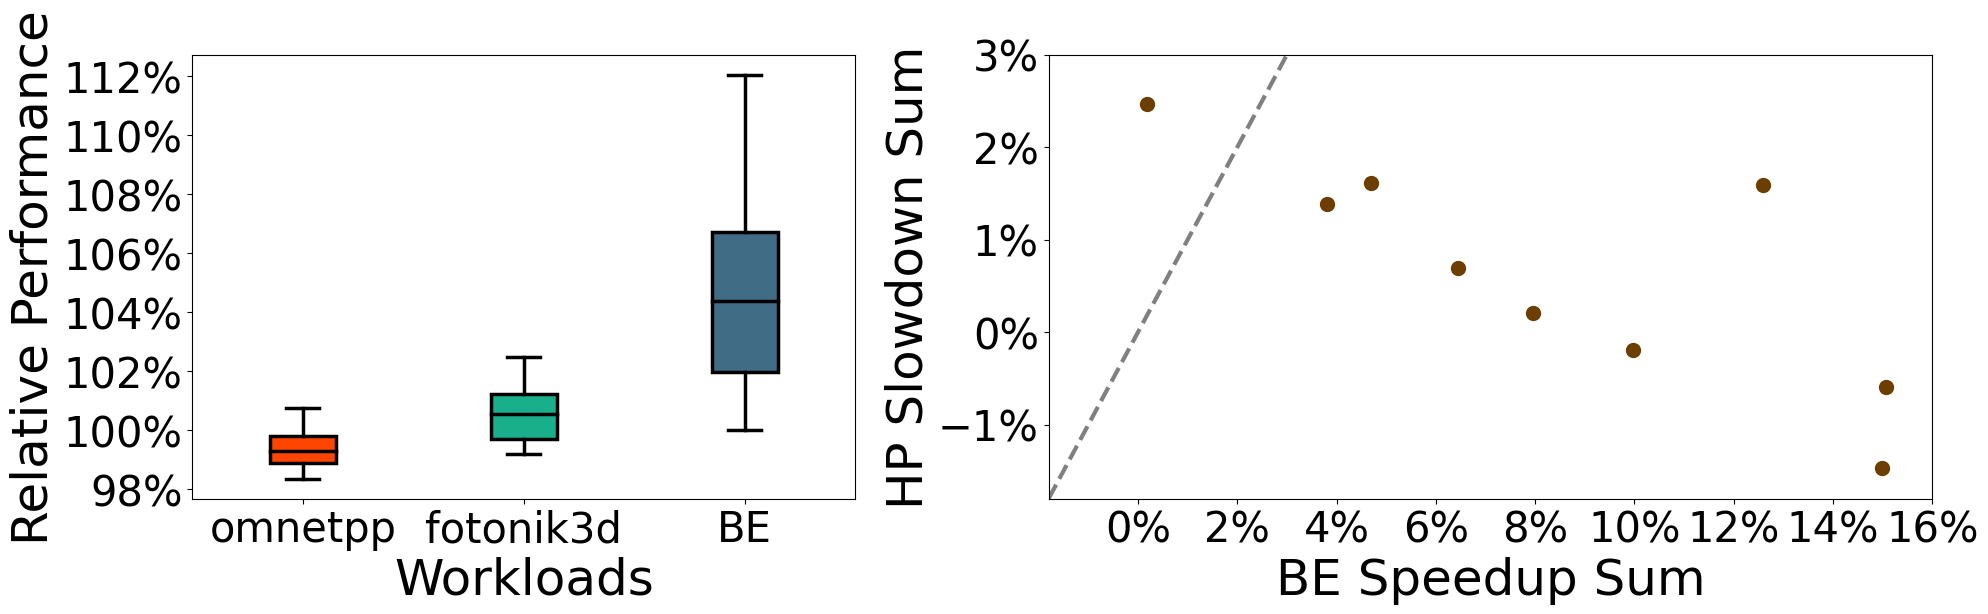

In [21]:

sheet32 = all_sheets['32bucket']

w0 = 'omnetpp'
w1 = 'fotonik3d'

select_hp_sheet = sheet32[(sheet32['workload0'] == w0) & (sheet32['workload1'] == w1)]

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]

data = [ [] for _ in range(napps) ]

hp_slowdown = []
be_speedup = []

for index,row in select_hp_sheet.iterrows():
    hp0 = row[exps[0]]
    hp1 = row[exps[1]]
    bes = [row[exps[j]] for j in range(2, ncore)]
    data[0].append(hp0)
    data[1].append(hp1)
    data[2].extend(bes)
    
    hp_slowdown.append(2-(hp0+hp1))
    be_speedup.append(np.sum(bes)-2)


print(min(data[0]))
print(min(data[1]))
print(min(data[2]))

print(len(be_speedup))
print(len(hp_slowdown))

xlabels = [w0, w1, 'BE']

# draw boxplots
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 2],
                        left=0.1, right=0.97,
                        top=0.93, bottom=0.19,
                        wspace=0.25, hspace=0)

ax = plt.subplot(gs[0, 0])
bp = ax.boxplot(data, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

box_step = 3


# set box colors alternatively
colors = contrasting_orange
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
# for i in range(1, len(xlabels)):
#     ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')

# set xlabels
# xlabel0_val = np.average(np.arange(1, box_step+1))
# ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(xlabels))])
ax.set_xticks(np.arange(1, box_step+1))
ax.set_xticklabels(xlabels)

ax.set_xlabel('Workloads')
ax.set_ylabel('Relative Performance')

# plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
#         # rotation_mode="anchor")
#         rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))


ax1 = plt.subplot(gs[0, 1])
sum_throughput = np.subtract(be_speedup, hp_slowdown)
print(len(sum_throughput))
ax1.scatter( be_speedup, hp_slowdown, marker='o', s=100,
            c=contrasting_orange[11])
            # c=sum_throughput,
            # cmap='winter' )
            # cmap='summer_r' )
ax1.add_line(Line2D([-1, 1], [-1, 1], color='gray', linewidth=3, linestyle='--'))
ax1.set_xlim(-0.018, 0.16)
ax1.set_ylim(-0.018, 0.03)
ax1.set_xlabel('BE Speedup Sum')
ax1.set_ylabel('HP Slowdown Sum')
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.01))

# set legend
# legends = [Patch(color=contrasting_orange[i],label=f'{app_labels[i]}')
#                     for i in range(napps)]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
# plt.title(exps[0])
# fig.set_size_inches((20,6))
# fig.tight_layout(pad=0)
# plt.subplots_adjust(top=1,bottom=0, wspace=0.2)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_2hp_select.png', dpi=300)